In [3]:
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
import numpy as np
from astropy.table import QTable
from astropy import units as u
import astropy.cosmology.units as cu
from matplotlib import pyplot as plt

from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp
from scipy.optimize import brentq

from nfw_profile_heating import NFWProfile

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)
from mcxc_clusters_as_nfw import load_clusters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
nfws = load_clusters()

/Users/eleanorstuart/Desktop/krisp/thermo-idm/mcxc_clusters_as_nfw.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=skipfooter)


In [18]:
nfw = nfws[10] # pick sample cluster

In [19]:
print(nfw.L500)

2.872451 1e+37 W


In [20]:
def get_Mbh_from_L500(nfw):
    logMbh = 10+0.38*np.log10(nfw.L500/(1e44*u.erg/u.s))
    return np.power(10, logMbh)*u.Msun

In [21]:
get_Mbh_from_L500(nfw)

<Quantity 1.49326195e+10 solMass>

In [22]:
def get_Linj_from_Mbh(Mbh):
    return 1e44*u.erg/u.s * (Mbh/(np.power(10, 9.5)*u.Msun))

In [23]:
get_Linj_from_Mbh(get_Mbh_from_L500(nfw))

<Quantity 4.72210891e+44 erg / s>

In [27]:
nfw.Linj(0.3*nfw.R500), nfw.Linj(0.1*nfw.R500)

(<Quantity 1.22539918e+46 erg / s>, <Quantity 1.70405061e+45 erg / s>)

In [30]:
Mbh_Linj = [get_Linj_from_Mbh(get_Mbh_from_L500(nfw)).to(u.erg/u.s).value for nfw in nfws]
Linj_03 = [nfw.Linj(0.3*nfw.R500).to(u.erg/u.s).value for nfw in nfws]
Linj_01 = [nfw.Linj(0.1*nfw.R500).to(u.erg/u.s).value for nfw in nfws]

Text(0, 0.5, 'Linj from Mbh (erg/s)')

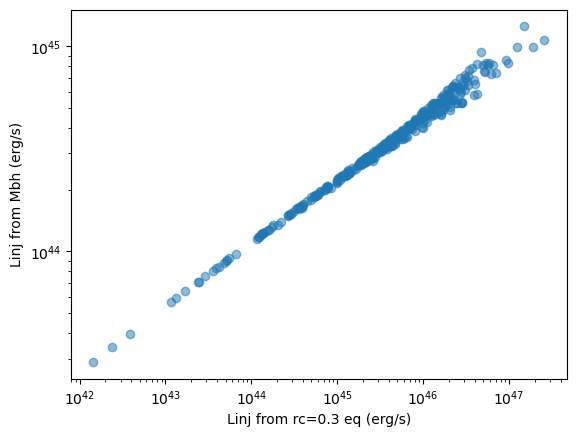

In [40]:
plt.scatter(Linj_03, Mbh_Linj, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Linj from rc=0.3 eq (erg/s)')
plt.ylabel('Linj from Mbh (erg/s)')

Text(0, 0.5, 'Linj(Mbh)/Linj(Mvir,rc=0.3r500)')

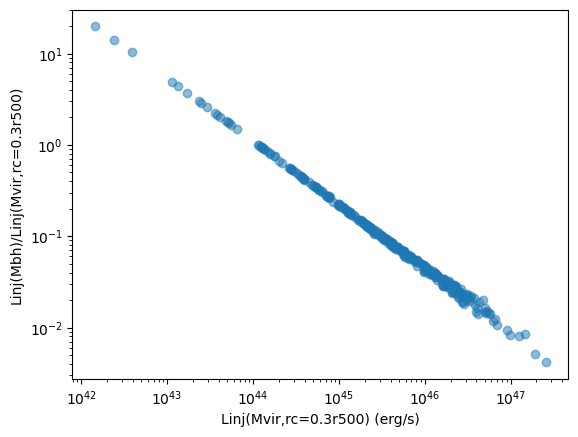

In [52]:
plt.scatter(Linj_03, np.divide(Mbh_Linj,Linj_03), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Linj(Mvir,rc=0.3r500) (erg/s)')
plt.ylabel('Linj(Mbh)/Linj(Mvir,rc=0.3r500)')

In [44]:
np.median(np.divide(Mbh_Linj,Linj_03))

0.07938586844978504

Text(0, 0.5, 'Linj from Mbh (erg/s)')

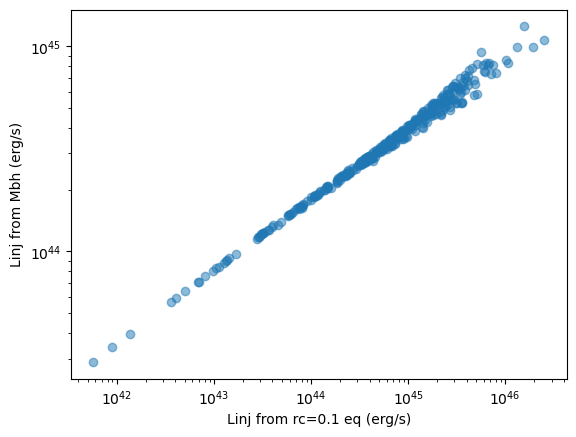

In [45]:
plt.scatter(Linj_01, Mbh_Linj, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Linj from rc=0.1 eq (erg/s)')
plt.ylabel('Linj from Mbh (erg/s)')

Text(0, 0.5, 'Linj(Mbh)/Linj(Mvir,rc=0.1r500)')

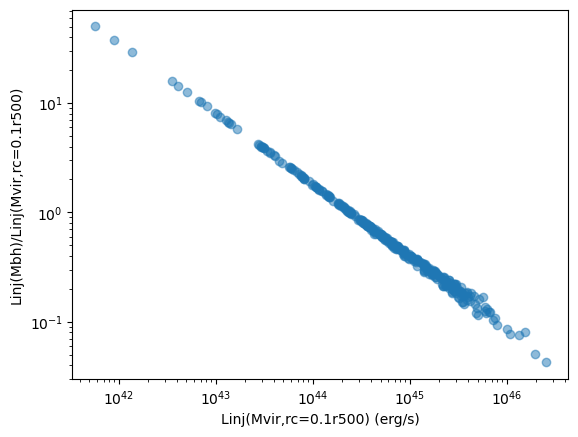

In [76]:
plt.scatter(Linj_01, np.divide(Mbh_Linj,Linj_01), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Linj(Mvir,rc=0.1r500) (erg/s)')
plt.ylabel('Linj(Mbh)/Linj(Mvir,rc=0.1r500)')

In [48]:
np.median(np.divide(Mbh_Linj,Linj_01))

0.5060195112088849

In [54]:
rs = np.logspace(-2, 1)*u.Mpc


In [55]:
vol_heating_rate_Mbh = nfw.vol_heating_rate(
    rs, 
    0.3*nfw.R500, 
    get_Linj_from_Mbh(get_Mbh_from_L500(nfw)))

In [65]:
vol_heating_rate_Mbh_01 = nfw.vol_heating_rate(
    rs, 
    0.1*nfw.R500, 
    get_Linj_from_Mbh(get_Mbh_from_L500(nfw)))

In [56]:
vol_heating_rate_Iq = nfw.vol_heating_rate(
    rs, 
    0.3*nfw.R500,)

In [64]:
vol_heating_rate_Iq_01 = nfw.vol_heating_rate(
    rs, 
    0.1*nfw.R500,)

In [57]:
vol_cooling_rate = nfw.vol_cooling_rate(rs)

Text(0.5, 0, 'r (Mpc)')

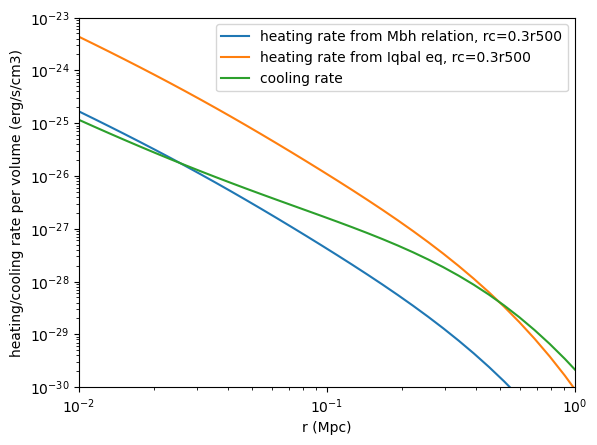

In [77]:
plt.loglog(rs, vol_heating_rate_Mbh, label='heating rate from Mbh relation, rc=0.3r500')
plt.loglog(rs, vol_heating_rate_Iq, label='heating rate from Iqbal eq, rc=0.3r500')
plt.loglog(rs, vol_cooling_rate, label='cooling rate')
plt.xlim(0.01, 1)
plt.ylim(1e-30, 1e-23)
plt.legend()
plt.ylabel('heating/cooling rate per volume (erg/s/cm3)')
plt.xlabel('r (Mpc)')

Text(0.5, 0, 'r (Mpc)')

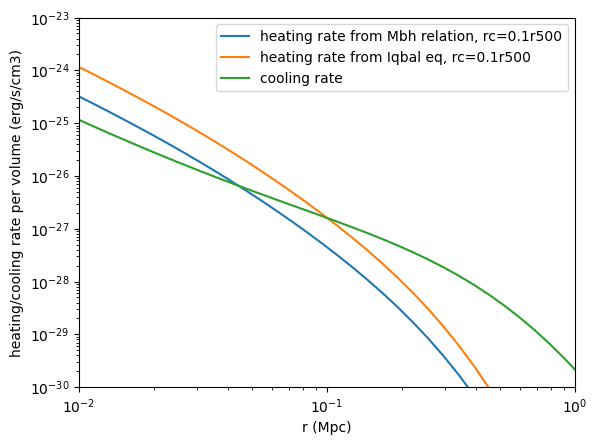

In [78]:
plt.loglog(rs, vol_heating_rate_Mbh_01, label='heating rate from Mbh relation, rc=0.1r500')
plt.loglog(rs, vol_heating_rate_Iq_01, label='heating rate from Iqbal eq, rc=0.1r500')
plt.loglog(rs, vol_cooling_rate, label='cooling rate')
plt.xlim(0.01, 1)
plt.ylim(1e-30, 1e-23)
plt.legend()
plt.ylabel('heating/cooling rate per volume (erg/s/cm3)')
plt.xlabel('r (Mpc)')

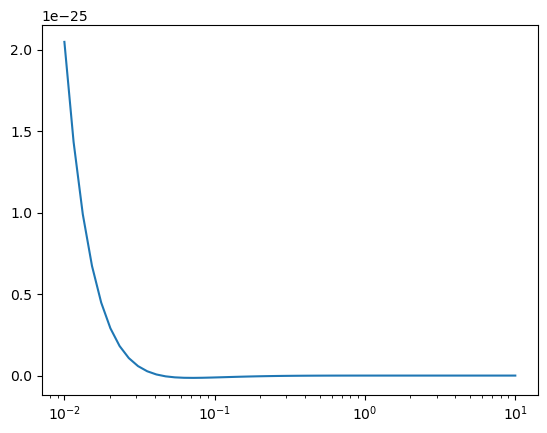

In [72]:
plt.plot(rs, vol_heating_rate_Mbh_01 - vol_cooling_rate)
plt.xscale('log')

In [74]:
s0 = 1e-27 * u.cm**2
m_chi = 1e-2*u.GeV
nfw.vol_dm_cooling_rate(rs, s0, m_chi, n=0, f_chi=1, m_psi=0.1*u.GeV)

<Quantity [6.24636650e-27, 5.43929739e-27, 4.71978995e-27, 4.07906540e-27,
           3.50935736e-27, 3.00379296e-27, 2.55628151e-27, 2.16141382e-27,
           1.81436110e-27, 1.51078717e-27, 1.24676223e-27, 1.01868625e-27,
           8.23222427e-28, 6.57239376e-28, 5.17766952e-28, 4.01964818e-28,
           3.07104519e-28, 2.30564699e-28, 1.69838089e-28, 1.22547757e-28,
           8.64698811e-29, 5.95593191e-29, 3.99741927e-29, 2.60957188e-29,
           1.65402440e-29, 1.01612425e-29, 6.04056742e-30, 3.46971185e-30,
           1.92326194e-30, 1.02769329e-30, 5.28985486e-31, 2.62176343e-31,
           1.25105624e-31, 5.74926475e-32, 2.54607819e-32, 1.08760883e-32,
           4.48709850e-33, 1.79066987e-33, 6.92438561e-34, 2.59951248e-34,
           9.49343666e-35, 3.37968327e-35, 1.17531201e-35, 4.00077678e-36,
           1.33570285e-36, 4.38197544e-37, 1.41513013e-37, 4.50616783e-38,
           1.41698324e-38, 4.40629093e-39] erg / (cm3 s)>